In [8]:
### Author: Gary Chen
### Date: June 13, 2023
### Last Updated: June 23, 2023
### Description: Forward and Inverse Radon Transform

try:
    import numpy as np
except Exception as e:
    print("numpy Importing exception")
try:
    import matplotlib.pyplot as plt
except Exception as e:
    print("matplotlib Importing exception")
try:
    import torch
except Exception as e:
    print("torch Importing exception")  
try:
    import torchvision.transforms.functional as F
except Exception as e:
    print("torch Importing exception")  
from torchvision import transforms
print('pytorch version is ', torch.__version__)
import os
current_directory = os.getcwd()
print("Current directory:", current_directory)
files = os.listdir(current_directory)
print(files)
#target_directory = '/Users/garychen/Desktop/2023SummerResearch/Ganapati/RadonTorch/dataset_foam' #on local mac
target_directory = '/global/u1/g/gchen4/RadonTorch/dataset_foam'
os.chdir(target_directory)

current_directory = os.getcwd()
print("Current directory:", current_directory)
files = os.listdir(current_directory)
print(files)

pytorch version is  1.13.1
Current directory: /global/u1/g/gchen4/RadonTorch/dataset_foam
['foam_training.npy', 'y_size.npy', 'radon comp 0.png', 'rotate images 0.png', 'x_size.npy', 'dataset_parameters.npy', 'x_train_sinograms.npy']
Current directory: /global/u1/g/gchen4/RadonTorch/dataset_foam
['foam_training.npy', 'y_size.npy', 'radon comp 0.png', 'rotate images 0.png', 'x_size.npy', 'dataset_parameters.npy', 'x_train_sinograms.npy']


Using device: cuda


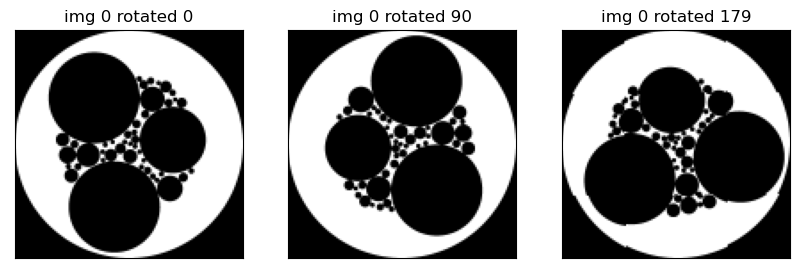

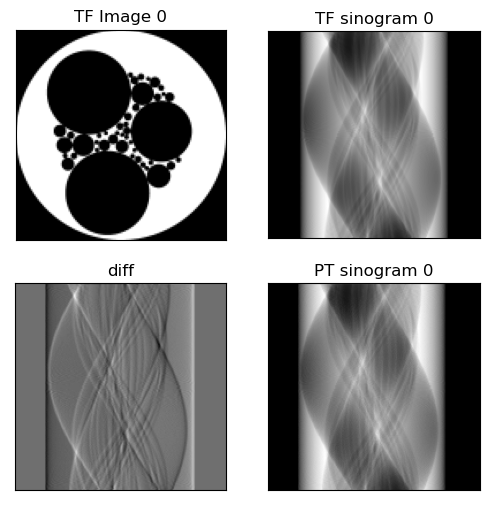

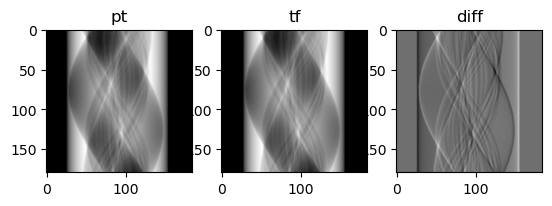

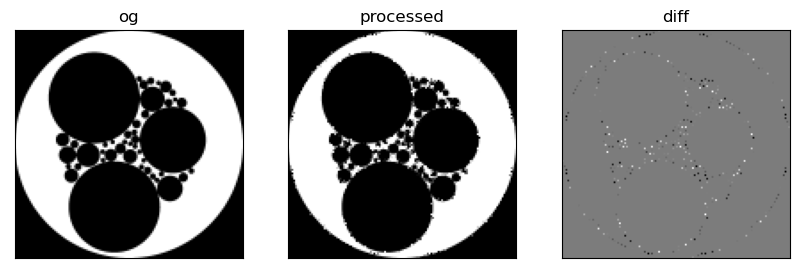

In [9]:
#%time # on Jupyter Notebook

class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor


class Radon_Transform:
    # convert the img to sinogram
    def __init__(self):
        self.theta_num = 180
        self.angles = np.arange(90, 270, dtype=float) # Angle list
        self.size_x = None
        self.size_y = None
        
    def img_to_rotated_imgs(self, image):
        # initialize the collection of rotated iamges as 180 by 128 by 128 empty arrays
        assert type(self.theta_num) == int
        rotated_imgs = torch.zeros((self.theta_num,128, 128))
        #rotated_imgs = torch.zeros((180,128, 128))
        # assign the unrotated img as the first img in the rotated collection
        rotated_imgs[0,:,:] = image
        self.size_x = image.shape[0]
        self.size_y = image.shape[0]
        for i in range(1,self.theta_num):
            #print(f"angle type is {type(self.angles[i])}")
            #print(f"angle  is {self.angles[i]}")
            rotated_image = F.rotate(image.unsqueeze(0), -self.angles[i]) #rotate function requires img in 3-d dimension
            rotated_imgs[i,:,:] = rotated_image
        return rotated_imgs
    
    def rotated_imgs_to_sinogram(self, rotated_images):
        # initialize the summing vector
        sum_vec = torch.ones((self.size_x, 1))
        sinogram = torch.zeros((180, 184))
        assert type(self.theta_num) == int
        for i in range(self.theta_num):
        #for i in range(180):
            # ith_p is the i-th row of the sinogram corresponding to each angle
            ith_p = torch.matmul(rotated_images[i,:,:],sum_vec) # 128 by 128 @ 128 by 1 means sum across the all rows of the img
            # Calculate start index for ith row in the sinogram 
            start = (sinogram.shape[0] - ith_p.shape[0]) // 2
            # Assign p values to the ith row of the sinogram, centered
            sinogram[i,start:start+ith_p.shape[0]] = ith_p.reshape(-1)
        return sinogram 

class Display_Image:
    # display the images and sinograms and compare our implementations with CT-PVAE
    
    def display_rotated_imgs(self, rotated_images, img_id):
        rotate_fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(rotated_images[0,:,:].cpu().numpy(), cmap='gray')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(f'img {img_id} rotated 0')
        ax[1].imshow(rotated_images[90,:,:].cpu().numpy(), cmap='gray')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title(f'img {img_id} rotated 90')
        ax[2].imshow(rotated_images[179,:,:].cpu().numpy(), cmap='gray')
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_title(f'img {img_id} rotated 179')
        rotate_fig.savefig(f"rotate images {img_id}")
        plt.show()
    
    def display_radon_transform(self, img, img_id, tf_sinogram,pt_sinogram):
        # Create a figure and a 1x2 subplot grid
        fig, axs = plt.subplots(2, 2, figsize=(6, 6))
        axs[0,0].imshow(img.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,0].set_title(f'TF Image {img_id}')
        axs[0,1].imshow(tf_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,1].set_title(f'TF sinogram {img_id}')
        axs[1,0].imshow(tf_sinogram.cpu().numpy()-pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,1].imshow(pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,0].set_title(f'diff')
        axs[1,1].set_title(f'PT sinogram {img_id}')

        # Remove the x and y ticks
        axs[0,0].set_xticks([])
        axs[0,0].set_yticks([])
        axs[0,1].set_xticks([])
        axs[0,1].set_yticks([])
        axs[1,0].set_xticks([])
        axs[1,0].set_yticks([])
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        
        fig.savefig(f"radon comp {img_id}")
        plt.show()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')
device = torch.device('cpu')

data_loader = Data_loader()
radon_tranformer = Radon_Transform()
displayer = Display_Image()
img_id = 2
images_tensor = data_loader.npy_to_tensor('foam_training.npy')
tf_sinograms_tensor = data_loader.npy_to_tensor('x_train_sinograms.npy')
for img_id in range(1):
    image = images_tensor[img_id,:,:]
    rotated_images = radon_tranformer.img_to_rotated_imgs(image)
    pt_sinogram = radon_tranformer.rotated_imgs_to_sinogram(rotated_images)
    tf_sinogram = tf_sinograms_tensor[img_id,:,:]
    displayer.display_rotated_imgs(rotated_images, img_id)
    displayer.display_radon_transform(image, img_id, tf_sinogram,pt_sinogram)

def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    '''
    print('img 1 is', image1[50:60, 50:60])
    print('img 2 is', image2[50:60, 50:60])
    print('diff is', image2.cpu().numpy()[50:60, 50:60]-image1.cpu().numpy()[50:60, 50:60])
    '''
    axs[2].set_title('diff')
    plt.show()
    
plot_2_img_tensor(pt_sinogram,tf_sinogram,"pt","tf")

'''
print("images shape", images_tensor.shape)
print("image1 shape", image.shape)
print("image1 dtpye", image.dtype)
print("tf_sinograms_tensor shape", tf_sinograms_tensor.shape)
print("tf_sinogram shape", tf_sinogram.shape)
print("tf_sinogram dtpye", tf_sinogram.dtype)
'''

rotate_angle = 60
a = rotated_images[0]
b = rotated_images[rotate_angle]
c = F.rotate(b.unsqueeze(0),rotate_angle+90)
c = c.reshape(128,128)
def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3,figsize=(10, 6))
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    axs[2].set_title('diff')
    for i in range(len(axs)):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()
plot_2_img_tensor(a,c,'og','processed')






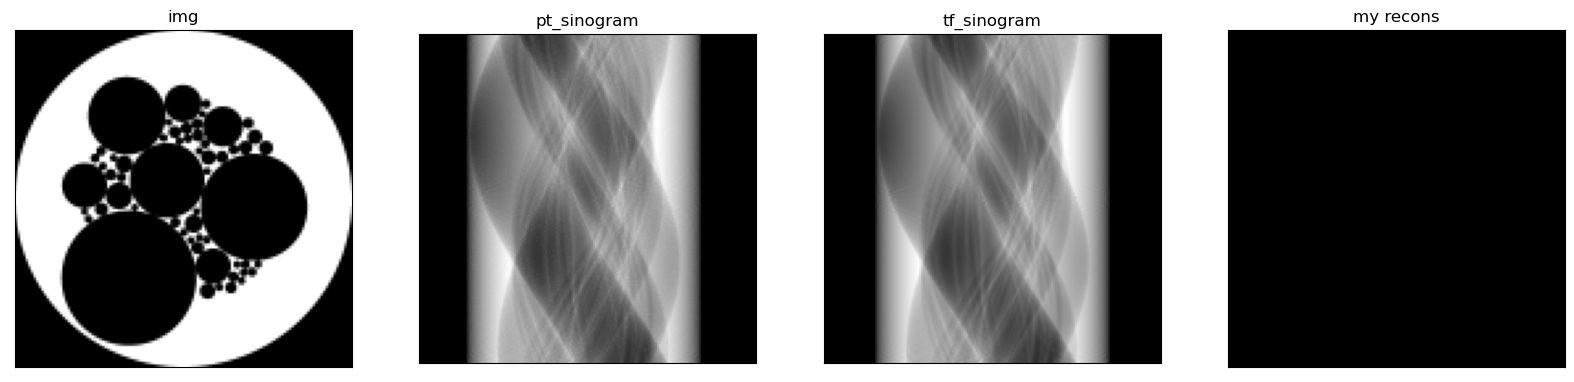

In [10]:
img_id = 1
image = images_tensor[img_id,:,:]
rotated_images = radon_tranformer.img_to_rotated_imgs(image)
pt_sinogram = radon_tranformer.rotated_imgs_to_sinogram(rotated_images)
tf_sinogram = tf_sinograms_tensor[img_id,:,:]
#displayer.display_rotated_imgs(rotated_images, img_id)
#displayer.display_radon_transform(image, img_id, tf_sinogram,pt_sinogram)

def plot_3_images(image1, image2, image3,image4, title1, title2, title3,title4):
    fig, axs = plt.subplots(1, 4,figsize=(20, 6))
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image3.cpu().numpy(), cmap='gray')
    axs[2].set_title(title3)
    axs[3].imshow(image4.cpu().numpy(), cmap='gray')
    axs[3].set_title(title4)
    for i in range(len(axs)):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()
    
my_recon = torch.zeros_like(image)


plot_3_images(image,pt_sinogram,tf_sinogram,my_recon,'img','pt_sinogram','tf_sinogram','my recons')

In [11]:
# inverse radon transform 
# input: sinogram from 180 angles
# output: the original image 
'''
process:
    1. initialize an empty 2d fourier array of size 128 by 128
    2. 1d fourier transform each row (angle) of sinogram into a tensor of different frequencies
    3. map the each frequency into the 2d fourier domain graph with formulas below:
        x = frequency * cos(angle)
        y = frequency * sin(angle)
        fourier_array[x,y] += projection_ft[ith-frequency]
    4. fill up the fourier array and perform a high pass filter on it
        high pass filter could be a linear ramp filter 
        high pass filter = (size the same as the fourier array with 0 at the center and radially increases outbound)
        filtered fourier array = fourier array * high pass filter (element wise multiplication)
    5. perform 2d inverse fourier transform to the filled and filtered fourier array
'''
def plot_1D_tensor(tensor):
    # Move tensor to CPU if it resides on a CUDA device
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # Convert tensor to a numpy array
    tensor_array = tensor.numpy()

    # Plot the tensor
    plt.plot(tensor_array)
    plt.title("1D Tensor Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()



In [12]:
import numpy as np # for the interpolation

In [13]:
def iradon(radon_image, theta=None, output_size=None,
           filter="ramp", interpolation="linear", circle=False):
    """
    Inverse radon transform.

    Reconstruct an image from the radon transform, using the filtered
    back projection algorithm.

    Parameters
    ----------
    radon_image : array_like, dtype=float
        Image containing radon transform (sinogram). Each column of
        the image corresponds to a projection along a different angle. The
        tomography rotation axis should lie at the pixel index
        ``radon_image.shape[0] // 2`` along the 0th dimension of
        ``radon_image``.
    theta : array_like, dtype=float, optional
        Reconstruction angles (in degrees). Default: m angles evenly spaced
        between 0 and 180 (if the shape of `radon_image` is (N, M)).
    output_size : int
        Number of rows and columns in the reconstruction.
    filter : str, optional (default ramp)
        Filter used in frequency domain filtering. Ramp filter used by default.
        Filters available: ramp, shepp-logan, cosine, hamming, hann.
        Assign None to use no filter.
    interpolation : str, optional (default 'linear')
        Interpolation method used in reconstruction. Methods available:
        'linear', 'nearest', and 'cubic' ('cubic' is slow).
    circle : boolean, optional
        Assume the reconstructed image is zero outside the inscribed circle.
        Also changes the default output_size to match the behaviour of
        ``radon`` called with ``circle=True``.

    Returns
    -------
    reconstructed : ndarray
        Reconstructed image. The rotation axis will be located in the pixel
        with indices
        ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.

    Notes
    -----
    It applies the Fourier slice theorem to reconstruct an image by
    multiplying the frequency domain of the filter with the FFT of the
    projection data. This algorithm is called filtered back projection.
    """
    radon_image = radon_image.to(device)
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')
    if theta is None:
        n, m = radon_image.shape # m is height and n is width; n is the number of projection and m is the number of pixels in each projection
        theta = torch.linspace(0,179,n).to(device)
    else:
        theta = torch.tensor(theta).to(device)
    if len(theta) != radon_image.shape[0]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")
    #perform high pass filter and inverse radon 
    pi = 3.14159265358979323846
    th = (pi / 180.0) * theta
    f = abs(torch.fft.fftfreq(128))*2
    f = f.to(device)
    omega = pi * f
    # shepp logan filter
    if filter == "ramp":
        pass
    elif filter == "shepp-logan":
        # Start from first element to avoid divide by zero
        f[1:] = f[1:] * torch.sin(omega[1:]) / omega[1:]
    elif filter == "cosine":
        f *= torch.cos(omega)
    elif filter == "hamming":
        f *= (0.54 + 0.46 * torch.cos(omega / 2))
    elif filter == "hann":
        f *= (1 + torch.cos(omega / 2)) / 2
    elif filter is None:
        f[:] = 1
    elif filter == "lifted_ramp":
        n = 128
        starting_point = 0.005
        x1 = torch.linspace(starting_point, 1, int(n/2)).to(device)
        x2 = torch.linspace(1,starting_point, int(n/2)).to(device)
        # Create an array that starts at 0.5, increases to 1 at the middle, 
        # then decreases to 0.5 at the end using absolute function
        y = torch.cat((x1, x2))
        #f = y.reshape(-1, 1)
        f = y.to(device)
    else:
        raise ValueError("Unknown filter: %s" % filter)
    
    radon_ft = torch.fft.fft2(radon_image, axis=1).to(device)
    assert radon_ft.shape == (180,128)
    radon_ft_filtered = radon_ft* f
    radon_filtered = torch.real(torch.fft.ifft2(radon_ft_filtered, axis=1))
    assert radon_filtered.shape == (180,128)
    # Resize filtered image back to original size
    radon_filtered = radon_filtered[:radon_image.shape[0], :]
    reconstructed = torch.zeros((output_size, output_size)).to(device)
    # Determine the center of the projections (= center of sinogram)
    mid_index = torch.tensor(radon_image.shape[1] // 2).to(device)

    x = torch.arange(output_size).to(device)
    y = torch.arange(output_size).to(device)
    X, Y = torch.meshgrid(x,y)
    xpr = X - int(output_size) // 2
    ypr = Y - int(output_size) // 2

    # Reconstruct image by interpolation
    for i in range(len(theta)):
        # th is thera in radians
        x = ypr * torch.cos(th[i]) - xpr * torch.sin(th[i])
        xp = torch.arange(radon_filtered.shape[1]).to(device) - mid_index
        fp = radon_filtered[i, :]
        backprojected = np.interp(x, xp, fp,left=0, right=0) #interpolate the projection data to the grid, but i'm not sure how numpy achieves this
        if i ==1:
            '''print(f'x shape is {x.shape}')
            print(f'xp shape is {xp.shape}')
            print(f'radon_filtered shape is {radon_filtered.shape}')
            print(f'backprojected shape is {backprojected.shape}')
            plot_1D_tensor(torch.tensor(backprojected))'''
            pass
        reconstructed += backprojected
    return reconstructed

torch.Size([180, 128])


/tmp/ipykernel_733326/2064379293.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon = torch.tensor(recon)


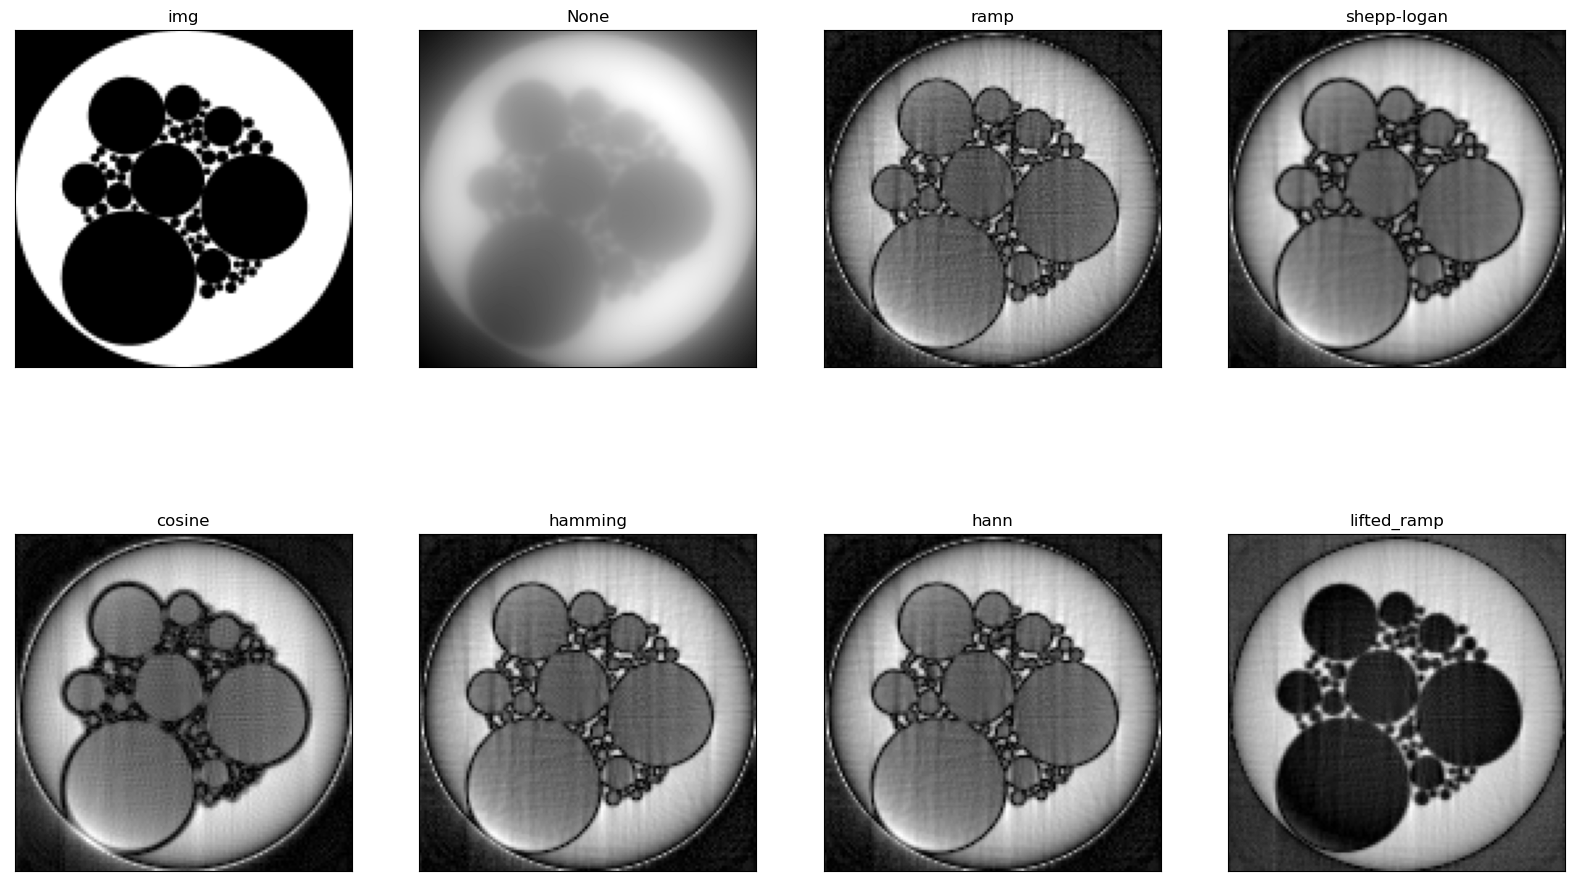

In [14]:

test_sinogram = tf_sinogram[:,28:28+128]
print(test_sinogram.shape)
filters = [None,'ramp','shepp-logan','cosine','hamming','hann','lifted_ramp']
#filters = ['ramp']
recons = []
for filter in filters:
    recon = iradon(test_sinogram, theta=None, output_size=128,filter=filter)
    recon = torch.tensor(recon)
    recons.append(abs(recon))
def plot_8_images(image1, title1, image2,title2, image3,title3,image4,title4,image5, title5, image6,title6, image7,title7,image8,title8):
    fig, axs = plt.subplots(2, 4,figsize=(20, 12))
    axs[0,0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0,0].set_title(title1)
    axs[0,1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[0,1].set_title(title2)
    axs[0,2].imshow(image3.cpu().numpy(), cmap='gray')
    axs[0,2].set_title(title3)
    axs[0,3].imshow(image4.cpu().numpy(), cmap='gray')
    axs[0,3].set_title(title4)
    axs[1,0].imshow(image5.cpu().numpy(), cmap='gray')
    axs[1,0].set_title(title5)
    axs[1,1].imshow(image6.cpu().numpy(), cmap='gray')
    axs[1,1].set_title(title6)
    axs[1,2].imshow(image7.cpu().numpy(), cmap='gray')
    axs[1,2].set_title(title7)
    axs[1,3].imshow(image8.cpu().numpy(), cmap='gray')
    axs[1,3].set_title(title8)
    for i in range(4):
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
    plt.show()

plot_8_images(image,'img',recons[0],'None',recons[1],filters[1],recons[2],filters[2],recons[3],filters[3],recons[4],filters[4]
              ,recons[5],filters[5],recons[6],filters[6])    

In [ ]:
# testing push on nersc